In [1]:
# essentials
import os
import pathlib

import pandas as pd
import numpy as np
from tqdm import tqdm

# visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MaxAbsScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.base import clone as clone_model

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.utils import compute_sample_weight, compute_class_weight


# others
import xgboost as xgb 
import lightgbm as lgb
import catboost as cb

In [2]:
RANDOM_SEED = 64

input_folder = "./data" # /kaggle/input/playground-series-s3e26
train_df = pd.read_csv(input_folder+ "/train.csv", index_col="id")
test_df = pd.read_csv(input_folder+"/test.csv", index_col="id")

target_column = "Status"

categorical_features = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]
numerical_features = ["N_Days", "Age", "Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]

train_df

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
id,,,,,,,,,,,,,,,,,,,
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,1166,D-penicillamine,16839,F,N,N,N,N,0.8,309.0,3.56,38.0,1629.0,79.05,224.0,344.0,9.9,2.0,C
7901,1492,Placebo,17031,F,N,Y,N,N,0.9,260.0,3.43,62.0,1440.0,142.00,78.0,277.0,10.0,4.0,C
7902,1576,D-penicillamine,25873,F,N,N,Y,S,2.0,225.0,3.19,51.0,933.0,69.75,62.0,200.0,12.7,2.0,D


### New features

In [3]:
def feature_engineering(df):
    #train_df['Status'] = train_df['Status'].map({"D": 0,"C": 1,"CL": 2})
    df['date_of_diagnosis'] = df['Age'] - df['N_Days']
    df['diseases'] = df['Ascites'] + df['Hepatomegaly'] + df['Spiders'] + df['Edema']

    # change categorical features to category type
    for col in categorical_features:
        df[col] = df[col].astype("category")

    # change "Stage" to string
    df["Stage"] = df["Stage"].apply(lambda x: str(x))
    return df

train_df = feature_engineering(train_df)

In [4]:
X = train_df.drop(columns=target_column)
y = train_df[target_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=RANDOM_SEED, stratify=y, shuffle=True)

print(f"Number of training examples: {len(X_train)}")
print(f"Number of validation examples: {len(X_val)}")

print("Number of examples per class in training set")
print(y_train.value_counts())

print("Number of examples per class in validation set")
print(y_val.value_counts())

le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)


Number of training examples: 7114
Number of validation examples: 791
Number of examples per class in training set
Status
C     4468
D     2398
CL     248
Name: count, dtype: int64
Number of examples per class in validation set
Status
C     497
D     267
CL     27
Name: count, dtype: int64


In [5]:
class_weight_keys = np.unique(y_train)
class_weight_values = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)

class_weights = dict(zip(class_weight_keys, class_weight_values))
class_weights

sample_weights = [ class_weights[j] for j in y_train]

In [6]:
models = {
    "xgboost": xgb.XGBClassifier(objective="multi:softprob", random_state=RANDOM_SEED, n_jobs=-1),
    "logistic_regression": LogisticRegression(random_state=RANDOM_SEED, multi_class="ovr", n_jobs=-1),
    "decision_tree": DecisionTreeClassifier(random_state=RANDOM_SEED),
    "random_forest": RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1),
    "gradient_boosting": GradientBoostingClassifier(random_state=RANDOM_SEED),
    "catboost": cb.CatBoostClassifier(random_state=RANDOM_SEED, verbose=False),
    "lightgbm": lgb.LGBMClassifier(random_state=RANDOM_SEED, n_jobs=-1, force_row_wise=True),
    "hist_gradient_boosting": HistGradientBoostingClassifier(random_state=RANDOM_SEED),
    "extra_trees": ExtraTreesClassifier(random_state=RANDOM_SEED),
}

In [7]:
log_dist = ['Bilirubin',   'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides',  'Prothrombin']
normal_dist = ['N_Days', 'Age', 'Cholesterol', 'Albumin', 'Platelets',]

numeric_transformer = Pipeline(
    [
        ("power_transformer", PowerTransformer()),
        ("scaler", MaxAbsScaler()),
    ]
)

categorical_transformer = Pipeline(
    [
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

models_scores = []

for model_name, model in tqdm(models.items()):
    try:
        clf = Pipeline(
            [
                ("preprocessor", preprocessor),
                ("classifier", CalibratedClassifierCV(model, cv=5)),
            ]
        )

        clf.fit(X_train, y_train)
        y_pred_proba = clf.predict_proba(X_val)
        y_pred = clf.predict(X_val)

        log_loss_score = log_loss(y_val, y_pred_proba)
    except Exception as e:
        print("Problem with model: ", model_name)
        print(e)
        log_loss_score = None

    models_scores.append({
        "model_name": model_name,
        "log_loss": log_loss_score
    })

models_scores_df = pd.DataFrame(models_scores).sort_values(by="log_loss", ascending=True)
models_scores_df

  0%|          | 0/9 [00:00<?, ?it/s]

 67%|██████▋   | 6/9 [00:44<00:31, 10.60s/it]

[LightGBM] [Info] Total Bins 1956
[LightGBM] [Info] Number of data points in the train set: 5691, number of used features: 28
[LightGBM] [Info] Start training from score -0.465201
[LightGBM] [Info] Start training from score -3.353336
[LightGBM] [Info] Start training from score -1.087603
[LightGBM] [Info] Total Bins 1948
[LightGBM] [Info] Number of data points in the train set: 5691, number of used features: 28
[LightGBM] [Info] Start training from score -0.464921
[LightGBM] [Info] Start training from score -3.358374
[LightGBM] [Info] Start training from score -1.087603
[LightGBM] [Info] Total Bins 1945
[LightGBM] [Info] Number of data points in the train set: 5691, number of used features: 28
[LightGBM] [Info] Start training from score -0.464921
[LightGBM] [Info] Start training from score -3.358374
[LightGBM] [Info] Start training from score -1.087603
[LightGBM] [Info] Total Bins 1943
[LightGBM] [Info] Number of data points in the train set: 5691, number of used features: 28
[LightGBM]

100%|██████████| 9/9 [00:55<00:00,  6.22s/it]


,model_name,log_loss
4,gradient_boosting,0.438751
7,hist_gradient_boosting,0.443300
5,catboost,0.450839
6,lightgbm,0.451550
0,xgboost,0.453523
3,random_forest,0.458304
8,extra_trees,0.475076
1,logistic_regression,0.497911
2,decision_tree,0.601768


In [9]:
base_model = StackingClassifier(
    estimators=[ (k, v) for k, v in models.items() ],
    n_jobs=-1
)
stacking_classifier_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", base_model),
    ]
)

stacking_classifier_pipeline.fit(X_train, y_train)

y_pred_proba = stacking_classifier_pipeline.predict_proba(X_val)
y_pred = stacking_classifier_pipeline.predict(X_val)

log_loss_score = log_loss(y_val, y_pred_proba)

models_scores.append({
    "model_name": "stacking_classifier",
    "log_loss": log_loss_score
})

# --------------------------------------------

base_model = VotingClassifier(
    estimators=[ (k, v) for k, v in models.items() ],
    voting="soft",
    n_jobs=-1
)
voting_classifier_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", base_model),
    ]
)

voting_classifier_pipeline.fit(X_train, y_train)
y_pred_proba = voting_classifier_pipeline.predict_proba(X_val)
y_pred = voting_classifier_pipeline.predict(X_val)

log_loss_score = log_loss(y_val, y_pred_proba)

models_scores.append({
    "model_name": "voting_classifier",
    "log_loss": log_loss_score
})

# --------------------------------------------

best_model_name = models_scores_df.iloc[1]["model_name"]
base_model = BaggingClassifier(
    estimator=clone_model(models["gradient_boosting"]),
    n_jobs=-1
)
clf = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", base_model),
    ]
)

clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_val)
y_pred = clf.predict(X_val)

log_loss_score = log_loss(y_val, y_pred_proba)

models_scores.append({
    "model_name": "bagging_classifier",
    "log_loss": log_loss_score
})

# -------------- RESULTS ----------------------

models_scores_df = pd.DataFrame(models_scores).sort_values(by="log_loss", ascending=True)
# remove duplicates
models_scores_df = models_scores_df.drop_duplicates(keep="first")
models_scores_df.to_csv("models_scores.csv", index=False, header=True)
models_scores_df

[LightGBM] [Info] Total Bins 1959
[LightGBM] [Info] Number of data points in the train set: 7114, number of used features: 28
[LightGBM] [Info] Start training from score -0.465124
[LightGBM] [Info] Start training from score -3.356391
[LightGBM] [Info] Start training from score -1.087430


KeyboardInterrupt: 

In [11]:
best_model_name = models_scores_df.iloc[0]["model_name"]

if best_model_name == "voting_classifier":
    clf = clone_model(voting_classifier_pipeline)
elif best_model_name == "stacking_classifier":
    clf = clone_model(stacking_classifier_pipeline)
else:
    best_model = clone_model(models["gradient_boosting"])
    clf = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("classifier", best_model),
        ]
    )

clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_val)
y_pred = clf.predict(X_val)

print(f"Log loss for {best_model_name}: {log_loss(y_val, y_pred_proba)}")
print(classification_report(y_val, y_pred, target_names=le.classes_))

Log loss for bagging_classifier: 0.4349009883095864
              precision    recall  f1-score   support

           C       0.83      0.94      0.88       497
          CL       0.50      0.11      0.18        27
           D       0.83      0.70      0.76       267

    accuracy                           0.83       791
   macro avg       0.72      0.58      0.61       791
weighted avg       0.82      0.83      0.82       791



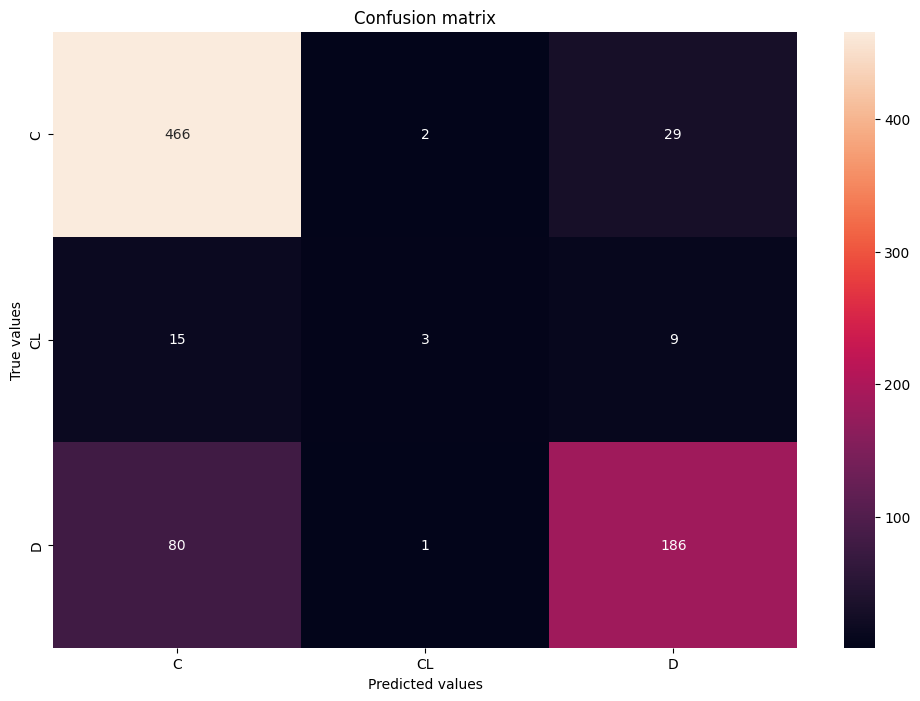

In [12]:
# visualise confusion matrix

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.title.set_text("Confusion matrix")
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='g', ax=ax)
ax.set_xticklabels(le.classes_)
ax.set_yticklabels(le.classes_)

# show on top of heatmap text "Predicted values"
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
plt.show()

## final submission

In [13]:
train_df = pd.read_csv("./data/train.csv", index_col="id")
test_df = pd.read_csv("./data/test.csv", index_col="id")

train_df = feature_engineering(train_df)
test_df = feature_engineering(test_df)

# change categorical features to category type
for col in categorical_features:
    train_df[col] = train_df[col].astype("category")
    test_df[col] = test_df[col].astype("category")

X_train = train_df.drop(columns=target_column)
y_train = le.transform(train_df[target_column])

X_test = test_df

model_1 : Pipeline = clone_model(voting_classifier_pipeline)
model_2 : Pipeline = clone_model(stacking_classifier_pipeline)
model_3 = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("classifier", clone_model(models["gradient_boosting"])),
        ]
    )

print("Fitting model1 ...")
model_1.fit(X_train, y_train)
print("Fitting model2 ...")
model_2.fit(X_train, y_train)
print("Fitting model3 ...")
model_3.fit(X_train, y_train)

y_pred_proba_1 = model_1.predict_proba(X_test)
y_pred_proba_2 = model_2.predict_proba(X_test)
y_pred_proba_3 = model_3.predict_proba(X_test)

measure_of_agreement = np.mean

y_pred_proba = measure_of_agreement([y_pred_proba_1, y_pred_proba_2, y_pred_proba_3], axis=0)

submission_df = pd.DataFrame(y_pred_proba, index=X_test.index, columns=[f"Status_{target}" for target in le.classes_])
submission_df.to_csv("./submission.csv")
submission_df

Fitting model1 ...
[LightGBM] [Info] Total Bins 1963
[LightGBM] [Info] Number of data points in the train set: 7905, number of used features: 28
[LightGBM] [Info] Start training from score -0.465082
[LightGBM] [Info] Start training from score -3.358480
[LightGBM] [Info] Start training from score -1.087291
Fitting model2 ...
[LightGBM] [Info] Total Bins 1963
[LightGBM] [Info] Number of data points in the train set: 7905, number of used features: 28
[LightGBM] [Info] Start training from score -0.465082
[LightGBM] [Info] Start training from score -3.358480
[LightGBM] [Info] Start training from score -1.087291
[LightGBM] [Info] Total Bins 1950
[LightGBM] [Info] Total Bins 1954
[LightGBM] [Info] Number of data points in the train set: 6324, number of used features: 28
[LightGBM] [Info] Number of data points in the train set: 6324, number of used features: 28
[LightGBM] [Info] Start training from score -0.465082
[LightGBM] [Info] Start training from score -3.358480
[LightGBM] [Info] Start tr

/home/wiktor/.pyenv/versions/3.10.11/envs/kaggling/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fitting model3 ...


,Status_C,Status_CL,Status_D
id,,,
7905,0.537007,0.036047,0.426946
7906,0.756264,0.072493,0.171243
7907,0.057828,0.020666,0.921506
7908,0.943238,0.007319,0.049443
7909,0.801923,0.035379,0.162698
...,...,...,...
13171,0.898827,0.031478,0.069695
13172,0.949209,0.008309,0.042482
13173,0.899351,0.011937,0.088712
